**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Job search model](#toc1_)    
- 2. [Problem 2: Fiscal sustainability](#toc2_)    
- 3. [Problem 3: Deferred acceptance algorithm](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from types import SimpleNamespace
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from Question3 import *

## 1. <a id='toc1_'></a>[Problem 1: Job search model](#toc0_)

Consider an unemployed agent searcing for jobs. <br>
There are $K$ jobs, job $k$ pays wage $w_k$. In each period the agent is offered one of the $K$ jobs, the likelihood of being offered job $k$ is $\pi_k$, with $\sum_{k=1}^K\pi_k=1$. <br>
The jobs are ordered by wage, such that $w_1<w_2<\dots<w_K$. <br>
$x^*\in\{1,2\dots,K+1\}$ is the lowest paying job that the person is willing to accept ($x^*=K+1$, means no job is accepted and the job seeker chooses to remain unemployed). <br>

Once a job is accepted the job is kept forever, so the value of employment at a given wage $w_k$ is:

$$
\begin{align*}
V_e(w_k)=\frac{u(w_k)}{1-\beta}
\end{align*}
$$
Where $u(w_k)$ is the utility of wage $w_k$ and $\beta$ is the discount factor. <br>

For a given $x$, and a given value of unemployment in the next period $V_u'$, the current value of umemployment is the utility of the unemployment benefit, $z$, plus the discounted expected value in the next period, which consists of the probability of being offered and accepting a job, times the value of employment at that wage, plus the likelihood of not being a offered job that the agent is willing to accept, times the value of being unemployed in next period. <br>
$$
V_u(x,V_u') = u(z)+ \beta\cdot \left( \sum_{k=x}^{K}\pi_k \cdot V_e(w_k) + V_u'\cdot \sum_{k=1}^{x-1}\pi_k  \right)
$$
$x^*$ is the optimal $x$ to maximize the value of being unemployed: <br>
$$
x^* = \underset{x\in\{1,2\dots,K+1\}}{\arg\max}V_u(x,V_u') 
$$
We specify:
$$
u(c)= \frac{c^{1-\rho}}{1-\rho}
$$

The parameters and the set of $\{w_k\}$ and $\{\pi_k\}$ are given as:

In [2]:
par = SimpleNamespace()
par.K = 100
par.w = np.linspace(1,8,par.K) # set of wage (w_k)
par.pi = np.exp(-par.w*2)/np.sum(np.exp(-par.w*2)) # Set of pi (pi_k)
par.rho = 0.5
par.z = 0.5
par.beta = 0.9
par.tol = 1e-6

**Question 1:** For a given $V_u'=30$, find $x^*$ nummerically, and calculate $V_u(x^*,V_u')$ . <br>

Relevant functions are defined and the optimal $x^*$ and maximum $V_u(x^*,V_u')$ is calculated. The indexing start at 1, meaning the loop runs from x = 1 to x = Par.K + 1.
 The indexing starts at zero meaning that the loop runs x = 0 to x = Par.K-1, which means that the code works directly with 0-based indexing for x.  Alternatively, the indexing can start at 1, meaning the loop runs from x = 1 to x = Par.K + 1.

In [3]:
# Fixed value of V_u'
V_u_prime = 30

# Define the utility function
def u(c, rho):
    return c ** (1 - rho) / (1 - rho)

# Define the value of being employed
def Ve(w, beta):
    return u(w, par.rho) / (1 - beta)

# Define the value of being unemployed for a given x and V_u'
def Vu(x, V_u_prime, par):
    expected_value = np.sum(par.pi[x:] * Ve(par.w[x:], par.beta)) + np.sum(par.pi[:x] * V_u_prime)
    return u(par.z, par.rho) + par.beta * expected_value

# Find the optimal x* that maximizes Vu
V_u_values = [Vu(x, V_u_prime, par) for x in range(par.K)]
optimal_x = np.argmax(V_u_values)
optimal_V_u = V_u_values[optimal_x]

print(f"Optimal x*: {optimal_x}")
print(f"Optimal V_u(x*, V_u'): {optimal_V_u}")


Optimal x*: 18
Optimal V_u(x*, V_u'): 28.624156394027825


The optimal $x^*$ = 18. This value indicates that the unemployed agent is willing to accept a job, with a wage of $18$ or higher. All jobs with a lower wage is not accepted, and the agent will remain unemployed, in hopes of receiving a higher paying job offer in the future.

When following the above optimal strategy, the maximum expected utility the agent can receive is is 28.62.



Note that the Optimal acceptance threshold $x*$ is an index, thus starting at 0, we decided to start at zero as the agent could technically work for free

$$
$$

There exists a unique value of $V_u'$, let's call it $V_u^*$,  that ensures that the current value of unemployment is equal to the value in the next period: $V_u^*=V_u(x^*,V_u^*)$. <br>
To find that value, we can use 2 tricks: <br>
First, the optimization over $x$ can be written out of the problem by using the fact that: <br>
$$
\begin{align*}
V_u(x^*,V_u') &= u(z)+ \beta\cdot \left( \sum_{k=x^*}^{K}\pi_k \cdot V_e(w_k) + V_u'\cdot \sum_{k=1}^{x^*-1}\pi_k  \right) \\
\Rightarrow V_u(x^*,V_u') = V_u(V_u') &=  u(z)+ \beta\cdot \left( \sum_{k=1}^{K}\pi_k \cdot \max\left\{V_e(w_k), V'_u\right\} \right)
\end{align*}
$$

Secondly, for finding the the value of $V_u^*$, a simple algorithm can be used: <br>
1. Start by setting $V_u'=0$
1. Calculate $V_u(V_u')$
1. If $\left|V_u(V_u')-V_u'\right|>\text{tol}$ set $V_u'=V_u(V_u')$ and go back to step 2. <br>
1. $V_u^*\approx V_u \approx V_u'$ is found. <br>

**Question 2:** For $z\in[0,4]$, solve for $V_u^*$ and plot it across $z$<br>
Then find $x^*$ and the following value $S$: 
$$
S = \beta \cdot \sum_{k=x^*}^{K}\pi_k \cdot V_e(w_k)
$$
And plot both across $z$

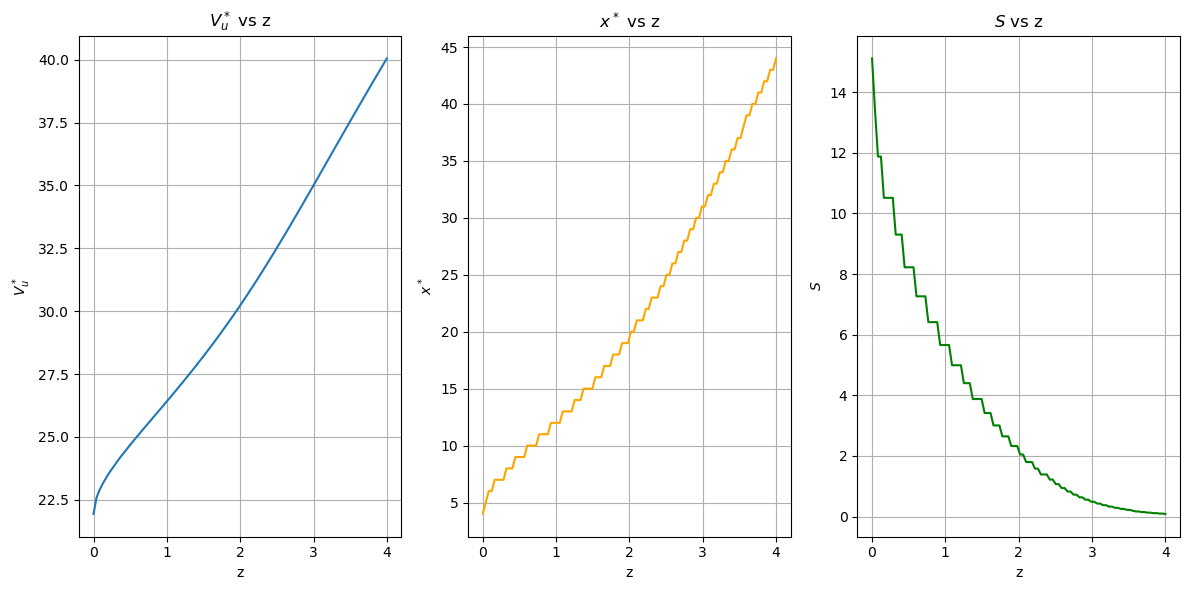

In [4]:
# Utility function
def u(c, rho):
    return (c**(1-rho)) / (1-rho)

# Employment value V_e(w_k)
def V_e(w_k, beta, rho):
    return u(w_k, rho) / (1-beta)

# Unemployment value V_u'(V_u')
def V_u_prime(V_u_prime, par, z):
    u_z = u(z, par.rho)
    return u_z + par.beta * np.sum(par.pi * np.maximum(V_e(par.w, par.beta, par.rho), V_u_prime))

# Solve for V_u^* using the iterative method
def solve_V_u_star(par, z):
    V_u_prime_value = 0
    while True:
        V_u_new = V_u_prime(V_u_prime_value, par, z)
        if np.abs(V_u_new - V_u_prime_value) < par.tol:
            break
        V_u_prime_value = V_u_new
    return V_u_new

# Solve for x* and S
def find_x_star_and_S(par, V_u_star, z):
    u_z = u(z, par.rho)
    for x in range(1, par.K+2):
        term1 = np.sum(par.pi[x-1:] * V_e(par.w[x-1:], par.beta, par.rho))
        term2 = V_u_star * np.sum(par.pi[:x-1])
        V_u_x = u_z + par.beta * (term1 + term2)
        if V_u_x >= V_u_star:
            x_star = x
            S = par.beta * term1
            return x_star, S

# Arrays to store results
z_values = np.linspace(0, 4, 100)
V_u_star_values = []
x_star_values = []
S_values = []

# Iterate over z values
for z in z_values:
    V_u_star = solve_V_u_star(par, z)
    x_star, S = find_x_star_and_S(par, V_u_star, z)
    
    V_u_star_values.append(V_u_star)
    x_star_values.append(x_star)
    S_values.append(S)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(z_values, V_u_star_values, label='$V_u^*$')
plt.xlabel('z')
plt.ylabel('$V_u^*$')
plt.title('$V_u^*$ vs z')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(z_values, x_star_values, label='$x^*$', color='orange')
plt.xlabel('z')
plt.ylabel('$x^*$')
plt.title('$x^*$ vs z')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(z_values, S_values, label='$S$', color='green')
plt.xlabel('z')
plt.ylabel('$S$')
plt.title('$S$ vs z')
plt.grid(True)

plt.tight_layout()
plt.show()

The leftmost graph plots the value of unemployment utility, that makes an agent indifferent between being unemployed, now and in the future $V_u^*$, against the unemployment benefit, $z$. As $z$ increases the value of unemployment $V_u^*$, also increases. This makes sense, since higher unemployment benefit, makes being unemployed less hard, in turn making unemployment more attractive.

The middle graph plots values of $x^*$, which is a measurement of the lowest paying job an agent is willing to accept, against the unemployment benefit, $z$. When $z$ increases, $x^*$ also increases. This indicates that the agent wants a higher paying job if unemployment benefits are rising. This makes sense, since the value of being unemployed is higher when $z$ is higher.

The rightmost graph plots $S$, the discounted sum of future wages for jobs that agents are willing to accept, against $z$, the unemployment benefits. As $z$ increases, $S$ decreases. This implies that higher unemployment benefits makes the agents anticipate lower cumulative future earnings. This hence alters his job searching behavior. 

Consider an updated version of the model where the job seeker can use search effort, $e$, to alter the offered job distribution. More search effort will increase the likelihood of being offered a high paying job, but it also directly hurts utility. <br>
$$
V_u(e,x,V_u') = u(z- e)+ \beta\cdot \left( \sum_{k=x}^{K}\pi(w_k,e) \cdot V_e(w_k) + V_u'\cdot \sum_{k=1}^{x-1}\pi(w_k,e)  \right)
$$
Where optimal values $e^*,x^*$ for a given $V_u'$ are:
$$
x^*,e^* = \arg\max_{x\in\{1,2\dots,K+1\}, e\in[0,z)}V_u(e,x,V_u')
$$
We specify the following functional form for $\pi(w_k,e)$:
$$ 
\pi(w,e) = \frac{\exp(-\frac{w}{\frac{1}{2}+e})}{\sum_{k=1}^{K}\exp(-\frac{w_k}{\frac{1}{2}+e})}
$$ 
$V_e(w_k)$ is the same as before.

**Question 3:** <br>
a) Plot $\pi(w,e)$ across $w\in[1,8]$ for $e\in\{0,0.2,0.5,1,2,10\}$. <br>
b) Solve for $x^*,e^*$ for a given $V_u'=30$. <br>

*Tip for b): You can solve for $x^*$ and $e^*$ by first creating a function that solves for $x^*$, given $e$, and returns the objective for the given $e$ and $x^*$, and then solves for $e^*$ by maximizing that function.*

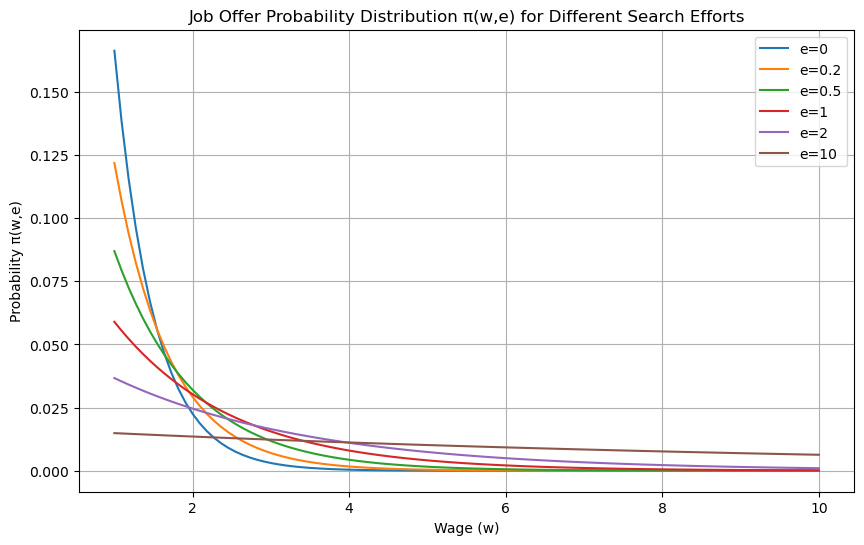

In [5]:
# Parameters
w = np.linspace(1, 10, 100)  # Wage values
e_values = [0, 0.2, 0.5, 1, 2, 10]  # Different levels of search effort

# Define the function pi(w,e)
def pi(w, e, w_set):
    denom = np.sum(np.exp(-w_set / (0.5 + e)))  # Denominator
    return np.exp(-w / (0.5 + e)) / denom  # Numerator divided by denominator

# Plotting
plt.figure(figsize=(10, 6))

for e in e_values:
    pi_values = pi(w, e, w)
    plt.plot(w, pi_values, label=f'e={e}')

plt.xlabel('Wage (w)')
plt.ylabel('Probability π(w,e)')
plt.title('Job Offer Probability Distribution π(w,e) for Different Search Efforts')
plt.legend()
plt.grid(True)
plt.show()


The plot shows how the distribution of job offer probabilities changes with the different levels of search effort. An agent with a low job searching effort, say $e=0$, has a higher probability of receiving job offers with a low wage. This probability decreases as wages increase. An agent with a high job searching effort has a much more steady probability of receiving a job offer, despite wages increasing. 

In [6]:
# Parameters
z = 0.5  # Unemployment benefit
V_u_prime = 30  # Given value

# Utility function
def u(c, rho):
    if rho == 1:
        return np.log(c)
    return (c ** (1 - rho)) / (1 - rho)

# Value of employment (as before)
V_e = u(w, 0.5) / (1 - 0.9)

# Function to calculate V_u(e, x, V_u')
def V_u(e, x, V_u_prime, w_set, V_e, pi_func):
    pi_vals = pi_func(w_set, e, w_set)
    accept_sum = np.sum(pi_vals[x - 1:] * V_e[x - 1:])
    reject_sum = np.sum(pi_vals[:x - 1])
    
    return u(z - e, 0.5) + 0.9 * (accept_sum + reject_sum * V_u_prime)

# Function to find x* for a given e
def find_x_star(e, V_u_prime, w_set, V_e):
    pi_vals = pi(w_set, e, w_set)
    V_u_vals = [u(z - e, 0.5) + 0.9 * (np.sum(pi_vals[x - 1:] * V_e[x - 1:]) + V_u_prime * np.sum(pi_vals[:x - 1])) for x in range(1, par.K + 2)]
    return np.argmax(V_u_vals)  # Add 1 for 1-based indexing

# Objective function to maximize over e
def objective(e, V_u_prime, w_set, V_e):
    x_star = find_x_star(e, V_u_prime, w_set, V_e)
    return -V_u(e, x_star, V_u_prime, w_set, V_e, pi)  # Negative because we want to maximize

# Solve for e* by maximizing the objective function
result = minimize_scalar(objective, bounds=(0, z), args=(V_u_prime, w, V_e), method='bounded')
e_star = result.x

# Solve for x* given e*
x_star = find_x_star(e_star, V_u_prime, w, V_e)

# Output e* and x*
print("Optimal search effort e*:", e_star)
print("Optimal acceptance threshold x*:", x_star)

Optimal search effort e*: 0.37110084588060543
Optimal acceptance threshold x*: 14


In the updated version of the model,  $x^*$ becomes 14, meaning that an agent wil now accept a job offer where the wage is greater than or equal to 14

The optimal level of search effort is found to be 0,3717. A higher level of search effort increases probability of receiving higher paying job offers. The value of 0,3717 indicates that the agent has found a balance where the marginal benefit of the increases probability of higher wages is exactly equal to the marginal cost of increasing search effort.


(Note that the Optimal acceptance threshold $e*$ is an index, thus starting at 0)

Again we can rewrite: 
$$
\begin{align*}
V_u(e,x^*,V_u')  &= u(z- e)+ \beta\cdot \left( \sum_{k=x^*}^{K}\pi(w_k,e) \cdot V_e(w_k) + V_u'\cdot \sum_{k=1}^{x^*-1}\pi(w_k,e)  \right) \\
\Rightarrow V_u(e,x^*,V_u') &= V_u(e,V_u') = u(z- e)+ \beta\cdot \left( \sum_{k=1}^{K}\pi(w_k,e) \cdot \max\left\{ V_e(w_k), V_u' \right\} \right)
\end{align*}
$$
With:
$$
e^* = \arg\max_{e\in[0,z)} V_u(e,V_u')

$$


Now $V_u^*$ can be found by the following procedure: <br>
1. Start by setting $V_u'=0$
1. Find $e^*$ given $V_u'$ and calculate $V_u(e^*,V_u')$
1. If $\left|V_u(e^*,V_u')-V_u'\right|>\text{tol}$ set $V_u'=V_u(e^*,V_u')$ and go to step 2. <br>
1. $V_u^*\approx V_u(e^*,V_u') \approx V_u'$ is found. <br>

**Question 4:** <br>
For $z\in[0,4]$, solve for $V_u^*$ in the new model and plot it across $z$<br>
Then find $x^*$, $e^*$ and the following value $S$: 
$$
S = \beta \cdot \sum_{k=x^*}^{K}\pi(w_k,e^*) \cdot V_e(w_k)
$$
And plot them across $z$. <br>
In the plots, compare with the values from question 2. <br>

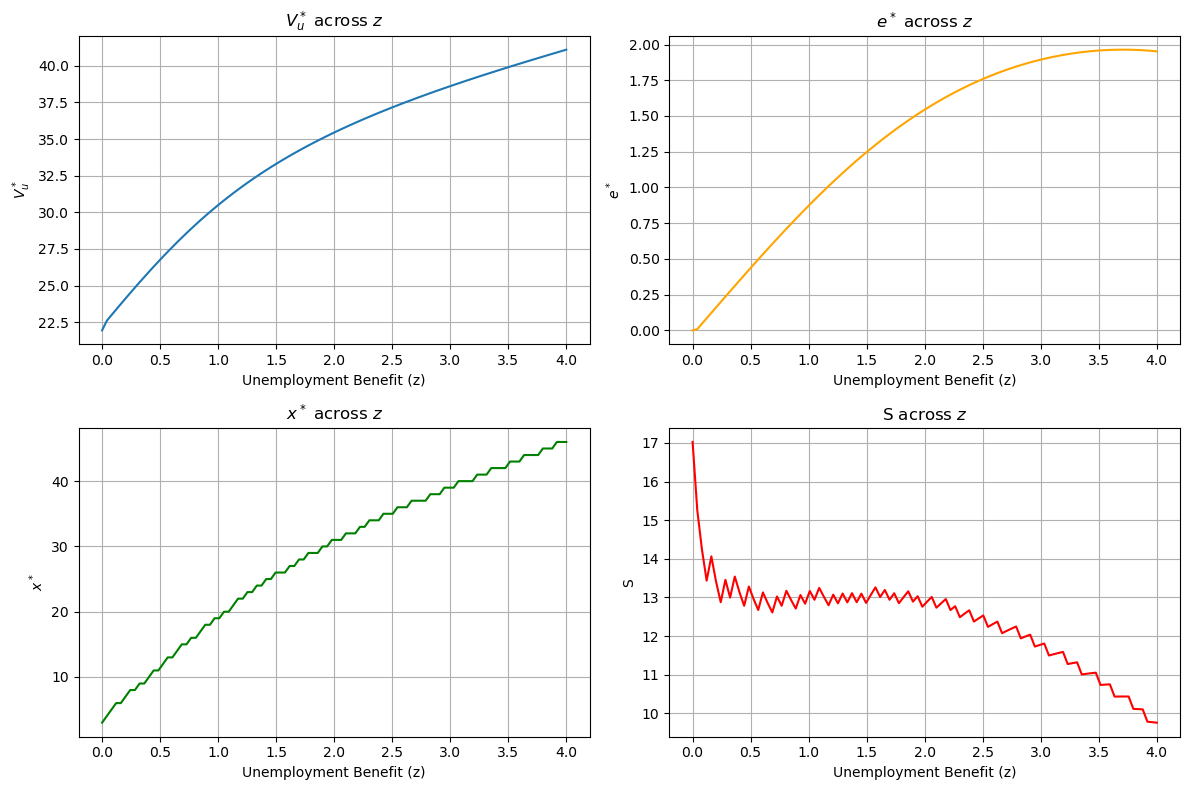

In [7]:
# Utility function
def u(c, rho):
    if rho == 1:
        return np.log(c)
    return (c ** (1 - rho)) / (1 - rho)

# Value of employment (as before)
V_e = u(par.w, par.rho) / (1 - par.beta)

# Probability function pi(w, e)
def pi(w, e, w_set):
    denom = np.sum(np.exp(-w_set / (0.5 + e)))  # Denominator
    return np.exp(-w / (0.5 + e)) / denom  # Numerator divided by denominator

# Unemployment value function V_u(e, V_u')
def V_u_func(e, V_u_prime, par, V_e, z):
    pi_vals = pi(par.w, e, par.w)
    return u(z - e, par.rho) + par.beta * np.sum(pi_vals * np.maximum(V_e, V_u_prime))

# Solve for V_u^* for different values of z
z_values = np.linspace(0, 4, 100)
V_u_star_values = []
e_star_values = []
x_star_values = []
S_values = []

for z in z_values:
    V_u_prime = 0  # Initial guess for V_u'
    
    while True:
        # Solve for e* given V_u_prime
        res = minimize_scalar(lambda e: -V_u_func(e, V_u_prime, par, V_e, z), bounds=(0, z), method='bounded')
        e_star = res.x
        V_u_new = -res.fun  # This is V_u(e^*, V_u')
        
        # Check for convergence
        if np.abs(V_u_new - V_u_prime) < par.tol:
            break
        
        V_u_prime = V_u_new
    
    V_u_star = V_u_new  # This is the converged V_u^*
    V_u_star_values.append(V_u_star)
    e_star_values.append(e_star)
    
    # Find x* for this value of V_u^* and e*
    pi_vals = pi(par.w, e_star, par.w)
    x_star = np.argmax(V_e >= V_u_star)
    x_star_values.append(x_star)
    
    # Calculate S
    S = par.beta * np.sum(pi_vals[x_star-1:] * V_e[x_star-1:])
    S_values.append(S)

# Convert results to numpy arrays for plotting
V_u_star_values = np.array(V_u_star_values)
e_star_values = np.array(e_star_values)
x_star_values = np.array(x_star_values)
S_values = np.array(S_values)

# Plot V_u^*, e^*, x^*, and S across different values of z
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(z_values, V_u_star_values, label='$V_u^*$')
plt.xlabel('Unemployment Benefit (z)')
plt.ylabel('$V_u^*$')
plt.title('$V_u^*$ across $z$')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(z_values, e_star_values, label='$e^*$', color='orange')
plt.xlabel('Unemployment Benefit (z)')
plt.ylabel('$e^*$')
plt.title('$e^*$ across $z$')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(z_values, x_star_values, label='$x^*$', color='green')
plt.xlabel('Unemployment Benefit (z)')
plt.ylabel('$x^*$')
plt.title('$x^*$ across $z$')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(z_values, S_values, label='S', color='red')
plt.xlabel('Unemployment Benefit (z)')
plt.ylabel('S')
plt.title('S across $z$')
plt.grid(True)

plt.tight_layout()
plt.show()


Like in problem 1.2, $V_u^*$, $x^*$, and $S$ are plotted against $z$. The expanded model now also includes e, which is also plotted against $z$.

In the $V_u^*$ graph, $V_u^*$ is increasing as $z$ increases, like in assignment 1.2, but now has a much larger curvature, compared to the previous graph. This indicates that including search effort, allows for more flexibility in optimizing $V_u^*$.

The graph for $x^*$, is likewise increasing as $z$ increases in the graph for the new model and is cuite similar, although there appears to be slighty more variability in $x^*$ in the updated model.

In 1.2 $S$ is decreasing as $z$ increases. In the updated model, this is not the case for all values of $z$. The discounted sum of future wages for jobs that agents are willing to accept decreases rapidly at low levels of $z$, but is generally slighty increasing, with minor variations, from $z$ values around 0.5 to 2, where a decreasing trend forms. This indicates that at low unemployment benefits, the agents anticipate low cummulative future earnings, while an unemployment benefit of around 0.5 to 2, provides a somewhat steady expectation of cummulative earnings and then from a $z$ value of 2 and onwards, the expected cummulative earnings for the agents continue to decline, as $z$ increases.

## 2. <a id='toc2_'></a>[Problem 2: Fiscal sustainability](#toc0_)

Consider the following model of fiscal sustainability:

$$
\begin{align*}
Y_{t+1}	&=(1+g)Y_{t}\\
B_{t+1}	&=(1+r)B_{t}+PD\cdot Y_t\\
b_{t}	&=\frac{B_{t}}{Y_{t}}\\
\end{align*}
$$

where $Y_{t}$ is GDP with growth rate $g$, $B_{t}$ is government bonds, $PD\in[0,1]$ is the primary deficit relative to GDP, and $b_{t}$ is the debt to GDP ratio.

Fiscal sustainability is defined as $\lim_{t\rightarrow\infty}b_{t}\rightarrow b_{ss}<\infty$. 

**Question 1:** Set $Y_{0}=1$, $B_{0}=0$, $g=0.02$ and $r=0.04$. Write code for simulating the model, how would you test for fiscal sustainability in your simulation? For which values of $PD$ is the fiscal policy sustainable?

#### Test for Fiscal Sustainability in the Simulation

To test for fiscal sustainability in the simulation, you need to evaluate whether the debt-to-GDP ratio $ b_t $ stabilizes over time or continues to increase indefinitely. Fiscal sustainability given as:

$$
\lim_{t \to \infty} b_{t} \to b_{ss} < \infty
$$

In practical terms, if $ b_t $ remains below a certain threshold (e.g., $ b_t < 2 $) and converges to a stable level over time, the policy is considered sustainable.

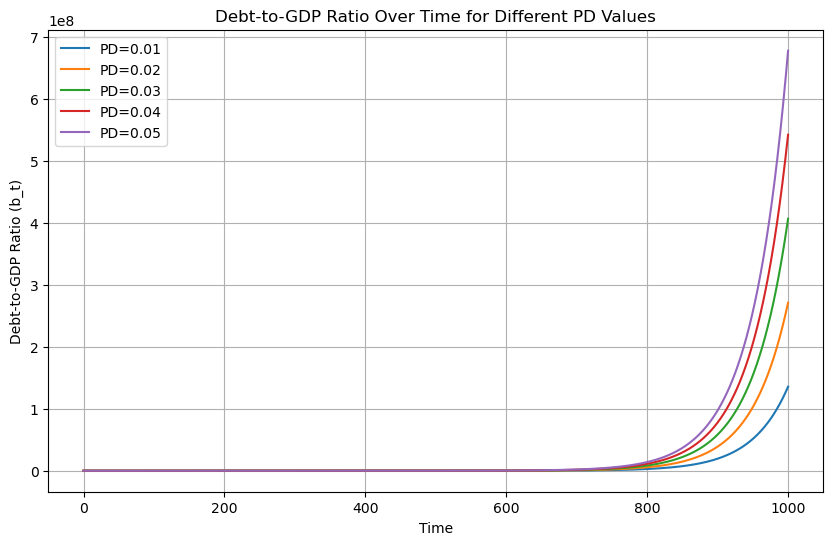

In [8]:
# Parameters
Y0 = 1      # Initial GDP
B0 = 0      # Initial government bonds
g = 0.02    # GDP growth rate
r = 0.04    # Interest rate on bonds
T = 1000    # Number of periods

# Simulation function
def simulate_fiscal_sustainability(PD, Y0, B0, g, r, T):
    Y = np.zeros(T+1)
    B = np.zeros(T+1)
    b = np.zeros(T+1)

    Y[0] = Y0
    B[0] = B0
    b[0] = B0 / Y0

    for t in range(T):
        Y[t+1] = (1 + g) * Y[t]
        B[t+1] = (1 + r) * B[t] + PD * Y[t]
        b[t+1] = B[t+1] / Y[t+1]

    return b

# Test different values of PD
PD_values = [0.01, 0.02, 0.03, 0.04, 0.05]

plt.figure(figsize=(10, 6))
for PD in PD_values:
    b = simulate_fiscal_sustainability(PD, Y0, B0, g, r, T)
    plt.plot(b, label=f'PD={PD}')

plt.title('Debt-to-GDP Ratio Over Time for Different PD Values')
plt.xlabel('Time')
plt.ylabel('Debt-to-GDP Ratio (b_t)')
plt.legend()
plt.grid(True)
plt.show()

The debt-to-GDP ratio increases indefinitely, suggesting that the model is not fiscally sustainable under the conditions simulated. The growth is exponential, implying that the debt level continues to rise without bound, which would lead to unsustainable fiscal outcomes in the long term.

**Question 2:** Set $Y_{0}=1$, $B_{0}=0$, $g=0.02$ and $r=0.00$. For which values of $PD$ is the fiscal policy sustainable? What if we also require $b_t < 2\,\forall t$  for sustainability?

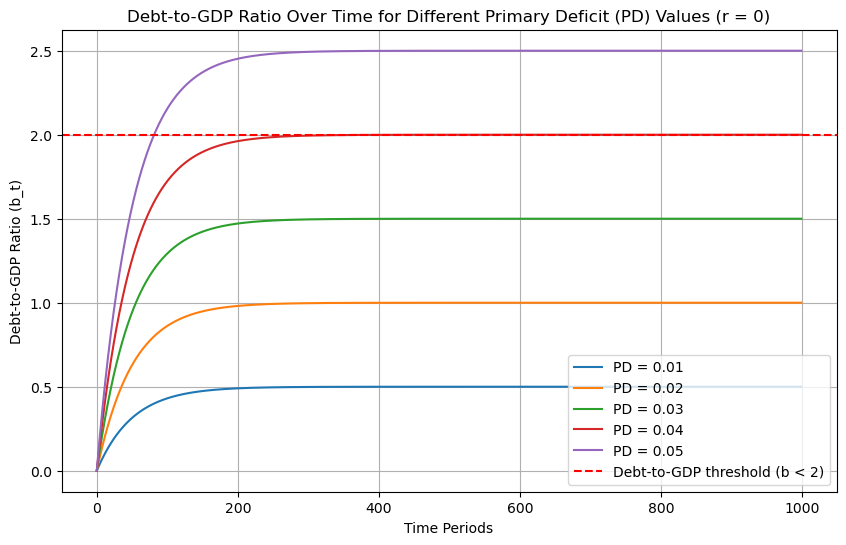

In [9]:
# Updated parameters for Question 2
Y0 = 1  # Initial GDP
B0 = 0  # Initial government bonds
g = 0.02  # GDP growth rate
r = 0.00  # Interest rate
T = 1000  # Number of periods to simulate

# Function to simulate the model with the new interest rate r = 0
def simulate_fiscal_sustainability_v2(PD, Y0=1, B0=0, g=0.02, r=0.00, T=1000):
    Y = [Y0]
    B = [B0]
    b = [B0 / Y0]  # Initial debt-to-GDP ratio

    for t in range(1, T):
        Y_new = (1 + g) * Y[-1]
        B_new = (1 + r) * B[-1] + PD * Y[-1]
        b_new = B_new / Y_new

        Y.append(Y_new)
        B.append(B_new)
        b.append(b_new)

    return b

# Testing different values of PD to check for sustainability with r = 0
PD_values = [0.01, 0.02, 0.03, 0.04, 0.05]
results = {}

# Simulate and store results for each PD value
for PD in PD_values:
    results[PD] = simulate_fiscal_sustainability_v2(PD)

# Plot the results
plt.figure(figsize=(10, 6))
for PD, b in results.items():
    plt.plot(b, label=f'PD = {PD}')

plt.axhline(y=2, color='r', linestyle='--', label='Debt-to-GDP threshold (b < 2)')
plt.title('Debt-to-GDP Ratio Over Time for Different Primary Deficit (PD) Values (r = 0)')
plt.xlabel('Time Periods')
plt.ylabel('Debt-to-GDP Ratio (b_t)')
plt.legend()
plt.grid(True)
plt.show()


For the given parameters the fiscal policy is always sustainable because we find a steady state, however when we include the Debt-to-GDP threshold we observe that the values $PD ≤ 0.04$ is the sustainable options which means that these values of $PD$, the debt-to-GDP ratio $b_{t}$ stabilizes over time, thus finding a feasible steady state, wheras $PD ≥ 0.05$ breach the threshold and does not find a true steady state.



Consider a stochastic version of the model above

$$
\begin{align*}
Y_{t+1}	&= (1+g_{t})Y_{t}\\
B_{t+1}	&=\left(1+ r_t \right)B_{t}+PD \cdot Y_t\\
b_{t}	&=\frac{B_{t}}{Y_{t}}\\
r_{t}	&= \exp ( \epsilon^r_{t} ) -1  + \nu b_t^2\\
g_{t}   &= \exp ( \epsilon^g_{t} )-1 \\
\epsilon^g_{t} 	&\sim\mathcal{\mathcal{N}}(\mu_{g},\sigma_{g}^{2})\\
\epsilon^r_{t}	&\sim\mathcal{\mathcal{N}}(\mu_{r},\sigma_{r}^{2})\\
\end{align*}
$$

where $\nu$ measure the interest rate sensivity. <br>
We have $Y_{0}=1$, $B_{0}=0$, $\mu_{g}=0.02$, $\sigma_{g}=0.02$, $\mu_{r}=0.00$, $\sigma_{r}=0.02$ and $\nu = 0.001$.

We now define the *probability of fiscal sustainabilit*y as the probability of always having $b_t < 2$ for $t < 500$. 

**Question 3**: What is the probability of fiscal sustainability as function of $PD$?

PD = 0.010, Probability of Fiscal Sustainability = 1.0000
PD = 0.014, Probability of Fiscal Sustainability = 1.0000
PD = 0.019, Probability of Fiscal Sustainability = 0.9980
PD = 0.023, Probability of Fiscal Sustainability = 0.8830
PD = 0.028, Probability of Fiscal Sustainability = 0.2810
PD = 0.032, Probability of Fiscal Sustainability = 0.0100
PD = 0.037, Probability of Fiscal Sustainability = 0.0000
PD = 0.041, Probability of Fiscal Sustainability = 0.0000
PD = 0.046, Probability of Fiscal Sustainability = 0.0000
PD = 0.050, Probability of Fiscal Sustainability = 0.0000


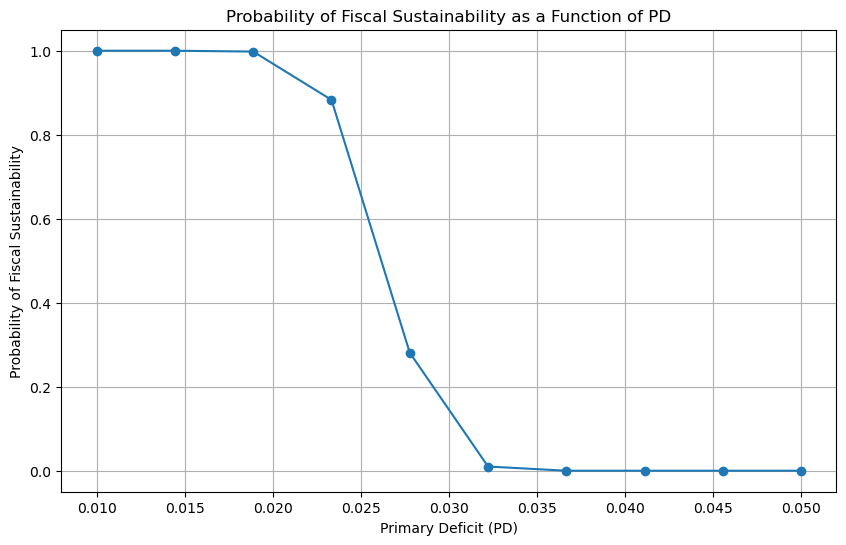

In [10]:
# Parameters
Y0 = 1      # Initial GDP
B0 = 0      # Initial government bonds
mu_g = 0.02 # Mean GDP growth rate
sigma_g = 0.02 # Std dev of GDP growth rate
mu_r = 0.00 # Mean interest rate
sigma_r = 0.02 # Std dev of interest rate
nu = 0.001 # Interest rate sensitivity to debt
T = 500    # Number of periods
num_simulations = 1000 # Number of simulations 

# Function to simulate one path
def simulate_one_path(PD, Y0, B0, mu_g, sigma_g, mu_r, sigma_r, nu, T):
    Y = Y0
    B = B0
    for t in range(T):
        epsilon_g = np.random.normal(mu_g, sigma_g)
        epsilon_r = np.random.normal(mu_r, sigma_r)
        g_t = np.exp(epsilon_g) - 1
        r_t = np.exp(epsilon_r) - 1 + nu * (B / Y) ** 2
        
        Y = (1 + g_t) * Y
        B = (1 + r_t) * B + PD * Y
        b_t = B / Y
        
        # Check if b_t exceeds 2
        if b_t >= 2:
            return False  # Not sustainable
    
    return True  # Sustainable if b_t < 2 for all t

# Function to calculate the probability of fiscal sustainability
def probability_of_sustainability(PD, Y0, B0, mu_g, sigma_g, mu_r, sigma_r, nu, T, num_simulations):
    num_sustainable = 0
    for _ in range(num_simulations):
        if simulate_one_path(PD, Y0, B0, mu_g, sigma_g, mu_r, sigma_r, nu, T):
            num_sustainable += 1
    return num_sustainable / num_simulations

# Range of PD values to test
PD_values = np.linspace(0.01, 0.05, 10)
sustainability_probs = []

for PD in PD_values:
    prob = probability_of_sustainability(PD, Y0, B0, mu_g, sigma_g, mu_r, sigma_r, nu, T, num_simulations)
    sustainability_probs.append(prob)
    print(f"PD = {PD:.3f}, Probability of Fiscal Sustainability = {prob:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(PD_values, sustainability_probs, marker='o')
plt.title('Probability of Fiscal Sustainability as a Function of PD')
plt.xlabel('Primary Deficit (PD)')
plt.ylabel('Probability of Fiscal Sustainability')
plt.grid(True)
plt.show()


The results demonstrate a the relationship between the primary deficit and fiscal sustainability. At low PD levels, the fiscal system is resilient and highly likely to be sustainable. However, as the PD increases beyond a critical threshold (beyond 0.28), the probability of sustainability drops very steeply. This sharp decline implies that even moderate deficits can lead to unsustainable outcomes if the PD exceed certain limits. When the probability of sustainability approaches zero, this indicates that the fiscal policy is unsustainable.

**Question 4:** Introduce and implement an extension of the model to make the fiscal sustainability analysis more interesting.

### Our extension described:

Our extension is to make the fiscal sustainability analysis more interesting is to introduce a **stochastic shock to the primary deficit $PD$**. In reality, the primary deficit can fluctuate due to various factors such as unexpected government expenditures, changes in tax revenue, or economic downturns. By allowing $PD$ to vary over time, we can capture the effects of these random shocks on fiscal sustainability.


### Model Extension:

We can model the primary deficit $PD_t$ as a stochastic process where it varies according to a normal distribution:

$$
PD_t = \mu_{PD} + \epsilon^{PD}_{t}, \quad \epsilon^{PD}_{t} \sim \mathcal{N}(0, \sigma_{PD}^{2})
$$

Here:
- $\mu_{PD}$ is the mean primary deficit.
- $\epsilon^{PD}_{t}$ represents the stochastic shock to the primary deficit at each time period, drawn from a normal distribution with standard deviation $\sigma_{PD}$.

This introduces an additional source of randomness into the model, making the sustainability analysis more realistic.


Probability of fiscal sustainability with stochastic PD: 0.99


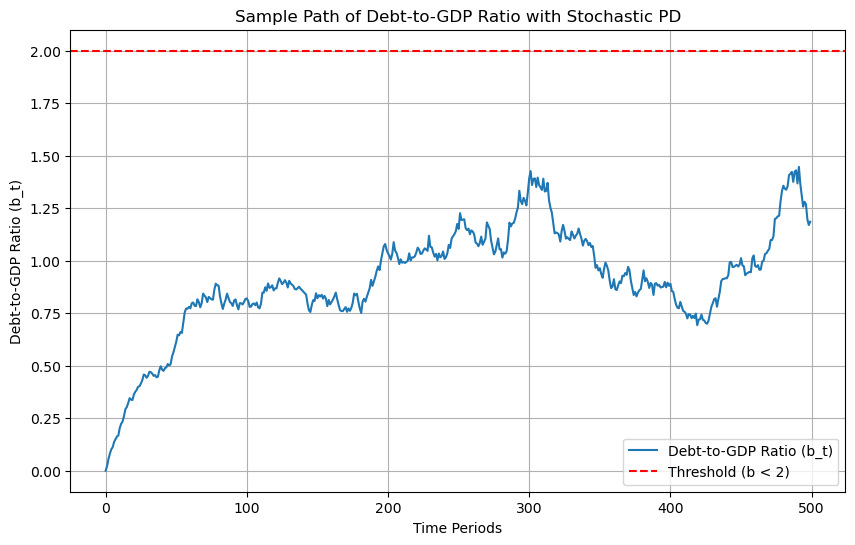

In [11]:
# Parameters for the extended stochastic model
Y0 = 1  # Initial GDP
B0 = 0  # Initial government bonds
mu_g = 0.02  # Mean of growth rate
sigma_g = 0.02  # Standard deviation of growth rate
mu_r = 0.00  # Mean of interest rate
sigma_r = 0.02  # Standard deviation of interest rate
nu = 0.001  # Interest rate sensitivity
mu_PD = 0.02  # Mean primary deficit
sigma_PD = 0.005  # Standard deviation of primary deficit shocks
T = 500  # Number of periods to simulate
simulations = 1000  # Number of simulation runs

# Function to simulate the extended stochastic model
def simulate_extended_stochastic_fiscal_sustainability(simulations=1000, T=500):
    sustainable_runs = 0
    
    for _ in range(simulations):
        Y = [Y0]
        B = [B0]
        b = [B0 / Y0]  # Initial debt-to-GDP ratio
        sustainable = True

        for t in range(1, T):
            # Generate stochastic shocks for g_t, r_t, and PD_t
            epsilon_g = np.random.normal(mu_g, sigma_g)
            epsilon_r = np.random.normal(mu_r, sigma_r)
            epsilon_PD = np.random.normal(0, sigma_PD)
            
            g_t = np.exp(epsilon_g) - 1
            r_t = np.exp(epsilon_r) - 1 + nu * b[-1]**2
            PD_t = mu_PD + epsilon_PD
            
            Y_new = (1 + g_t) * Y[-1]
            B_new = (1 + r_t) * B[-1] + PD_t * Y[-1]
            b_new = B_new / Y_new

            Y.append(Y_new)
            B.append(B_new)
            b.append(b_new)
            
            # Check if b_t exceeds the threshold of 2
            if b_new >= 2:
                sustainable = False
                break
        
        if sustainable:
            sustainable_runs += 1

    # Probability of fiscal sustainability
    return sustainable_runs / simulations

# Running the simulation and calculating the probability of sustainability
probability = simulate_extended_stochastic_fiscal_sustainability()
print(f"Probability of fiscal sustainability with stochastic PD: {probability:.2f}")

# Plotting a sample path for illustration
Y_sample = [Y0]
B_sample = [B0]
b_sample = [B0 / Y0]
PD_sample = []

for t in range(1, T):
    epsilon_g = np.random.normal(mu_g, sigma_g)
    epsilon_r = np.random.normal(mu_r, sigma_r)
    epsilon_PD = np.random.normal(0, sigma_PD)
    
    g_t = np.exp(epsilon_g) - 1
    r_t = np.exp(epsilon_r) - 1 + nu * b_sample[-1]**2
    PD_t = mu_PD + epsilon_PD
    
    Y_new = (1 + g_t) * Y_sample[-1]
    B_new = (1 + r_t) * B_sample[-1] + PD_t * Y_sample[-1]
    b_new = B_new / Y_new

    Y_sample.append(Y_new)
    B_sample.append(B_new)
    b_sample.append(b_new)
    PD_sample.append(PD_t)

plt.figure(figsize=(10, 6))
plt.plot(b_sample, label="Debt-to-GDP Ratio (b_t)")
plt.axhline(y=2, color='r', linestyle='--', label='Threshold (b < 2)')
plt.title('Sample Path of Debt-to-GDP Ratio with Stochastic PD')
plt.xlabel('Time Periods')
plt.ylabel('Debt-to-GDP Ratio (b_t)')
plt.grid(True)
plt.legend()
plt.show()


**Explanation:**

The implementation introduces randomness into the primary deficit $PD$, which fluctuates over time according to a stochastic process. The simulation then evaluates whether the debt-to-GDP ratio remains below the threshold $b_t < 2$ for all time periods, considering these random fluctuations.

The output provides the probability of fiscal sustainability under this extended model, making the analysis more realistic and dynamic.

## 3. <a id='toc3_'></a>[Problem 3: Deferred acceptance algorithm](#toc0_)

Consider a matching problem with students and mentors. <br>
There are $S$ students, $s_1,s_2,\dots s_S$ and $M$ mentors $m_1,m_2,\dots m_M$  <br>
All have preferences over each other, meaning student $s_i$ gets utility $u_{s_i}(m_j)$ from working with mentor $m_j$ and mentor $m_j$ gets utility $u_{m_j}(s_i)$ from mentoring student $s_i$. <br>
Their preferences are independent of each other, $u_{s_i}(m_j)\sim U[0,1],\;u_{m_j}(s_i)\sim U[0,1]$.<br>
They all don't want to work alone, meaning $u_{s_i}(Ø) = u_{m_j}(Ø) = 0$, and can only work with one single person. <br>
A matching prescribes a mapping between students and mentors such that all students and mentors either have a unique partner or are unmatched. <br>
It can be defined as a function $\mu$ that uniquely maps students to mentors and mentors to students. <br>
$$
\begin{align*}
    \mu(a) = \begin{cases}
        m_j & \text{if } a \text{ is matched to } m_j \\
        s_i & \text{if } a \text{ is matched to } s_i \\
        Ø & \text{if } a \text{ is unmatched}
    \end{cases}
\end{align*}
$$
For all $a\in \left\{s_1,s_2,\dots s_S,m_1,m_2,\dots m_M\right\}$. <br>
For a given matching, a *blocking pair* is a pair $(s_i,m_j)$ such that $s_i$ and $m_j$ are not matched to each other in the matching, but both prefer each other to their current partners. Meaning that $u_{s_i}(m_j) > u_{s_i}(\mu(s_i))$ and $u_{m_j}(s_i) > u_{m_j}(\mu(m_j))$ would identify a blocking pair. <br>
A *stable matching* is a matching with no blocking pairs. <br>

**Deffered Acceptance Algorithm (DAA)**<br>
DAA is an algorithm that finds a stable matching. <br>
One of the groups proposes to members of the other group, and members of the other group considers the offers they have received. This continues in a loop until a stable matching is found. <br>
We will call the proposing group $P$ and the receiving group $R$.  <br>
If the students propose, then we say $S=P$ with $s_i=p_i\forall i$, and $M=R$ with $m_j=r_j \forall j$, and vice versa.

The algorithm is as follows:

1. All $p_i$ who do not have an outstanding offer, (because it is the first round, or because their offer was rejected in the previous round) propose to the $r_j$ whom they prefer the most, among those that have not rejected them yet. If they have been rejected by all $r_j$ they remain unmatched. <br>
    If all $p_i$ either have an outstanding offer or have been rejected by all $r_j$, then go to step 4. <br>

1. If a $r_j$ has one offer, they hold on to that offer. <br>
    If a $r_j$ has more than one offer (including the offer they might have held on to), they hold on to their favorite offer and reject the rest. <br>

1. Go back to step 1. <br>

1. The resulting matching is stable. <br>



The below code should help you get started, read through through it and make sure you understand it. Then make the changes necessary to answer the questions. (Feel free to move it into a .py-file)

In [12]:
# Setup
np.random.seed(2000)

# Initiate the model and simulate preferences
Mmodel = MatchingModel(M=7,S=7)
par = Mmodel.par
Mmodel.simulate_preferences()

In [13]:
# Print the current prescribed matching
Mmodel.print_matching()

Matching
Students:
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone

Mentors
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone
{(s:m)} : {(None,1), (None,2), (None,3), (None,4), (None,5), (None,6), (None,7), }


In [14]:
# Check whether the current matching is stable
Mmodel.check_matching()

Error: student 1 and mentor 1 are a blocking pair


It is not stable because nobody has a partner, and everybody would prefer working with somebody as opposed to alone

In [15]:
# We can loop through all students and get the id of the mentor they would want to offer to first
offers = [s.next_offer() for s in par.S_list]
for i, offer in enumerate(offers):
    print(f'Student {i+1} offers to mentor {offer+1}')

Student 1 offers to mentor 1
Student 2 offers to mentor 7
Student 3 offers to mentor 2
Student 4 offers to mentor 7
Student 5 offers to mentor 7
Student 6 offers to mentor 6
Student 7 offers to mentor 4


In [16]:
# For given list of offers we can then see the mentors reaction
m7 = par.M_list[6]
choice = m7.react_to_offer(offers,printit=True)
print(f'm7 chooses to hold on to the offer from student {choice+1}')

m7 chooses to hold on to the offer from student 5


In [17]:
# We can then tell student 5 that they have an outstanding offer from mentor 7
s5 = par.S_list[4]
s5.partner = 6

# And see our new current matching
Mmodel.print_matching()

Matching
Students:
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works with 7
Person 6 works alone
Person 7 works alone

Mentors
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works with 5
{(s:m)} : {(None,1), (None,2), (None,3), (None,4), (None,5), (None,6), (5,7), }


In [18]:
# We can reset all persons
Mmodel.reset()
Mmodel.print_matching()

Matching
Students:
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone

Mentors
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone
{(s:m)} : {(None,1), (None,2), (None,3), (None,4), (None,5), (None,6), (None,7), }


**Question 1:** Use DAA to find the stable matching when students propose. <br>

In [19]:
Mmodel.DAA()

Starting DA algorithm
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Matching
Students:
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone

Mentors
Person 1 works with 1
Person 2 works with 5
Person 3 works with 5
Person 4 works with 2
Person 5 works with 6
Person 6 works with 7
Person 7 works with 5
{(s:m)} : {(1,1), (5,2), (5,3), (2,4), (6,5), (7,6), (5,7), }


**The conclusion from the output of Question 1 is that the matching is not stable and has several issues.**

First, all students (Persons 1 to 7) are unmatched and are shown as working alone. This indicates that the Deferred Acceptance Algorithm (DAA) did not successfully match students with mentors, which is an unexpected outcome for a stable matching.

Second, some mentors have conflicting matches. For example, Mentors 2, 3, and 7 are all matched with Student 5, which is an invalid scenario. In a stable matching, no mentor should be paired with the same student as another mentor.

The algorithm failed to achieve a stable matching, as indicated by the conflicting matches and unmatched students.


**Question 2:** Use DAA to find the stable matching when mentors propose. <br>

In [20]:
Mmodel.DAA(proposers='M')

Starting DA algorithm
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Matching
Students:
Person 1 works with 1
Person 2 works with 7
Person 3 works with 2
Person 4 works with 7
Person 5 works with 7
Person 6 works with 6
Person 7 works with 4

Mentors
Person 1 works alone
Person 2 works alone
Person 3 works alone
Person 4 works alone
Person 5 works alone
Person 6 works alone
Person 7 works alone
{(s:m)} : {(None,1), (None,2), (None,3), (None,4), (None,5), (None,6), (None,7), }


**The conclusion from the output of Question 2 is that the matching is not stable and contains significant issues.**

First, all mentors (Persons 1 to 7) are unmatched and are shown as working alone. This suggests that when mentors propose, the Deferred Acceptance Algorithm (DAA) did not properly match mentors with students, resulting in an unexpected and invalid outcome.

Second, all students are matched, but the output shows that multiple students are matched with the same mentor. For example, Mentor 7 is matched with Students 2, 4, and 5, which is not a valid stable matching since each mentor should be paired with only one student.

The algorithm failed to produce a stable matching, as shown by the unmatched mentors and conflicting student-mentor pairings.


**Question 3:** Find all other stable matches. <br>
*Hint: Everybody prefers working with somebody as opposed to alone, this means that no one will be alone in a stable matching, because both groups are equal in size.*

In [21]:
Mmodel.find_all_stable_matches()

[(0, 1, 4, 2, 6, 5, 3), (0, 2, 3, 1, 6, 4, 5), (0, 2, 4, 1, 6, 5, 3)]

**The output of Question 3 shows that there are three stable matchings found:**

**Matching 1:** 
* Student 0 → Mentor 1, 
* Student 1 → Mentor 4, 
* Student 2 → Mentor 2, 
* Student 3 → Mentor 6, 
* Student 4 → Mentor 5, 
* Student 5 → Mentor 3

**Matching 2:** 
* Student 0 → Mentor 2, 
* Student 1 → Mentor 3, 
* Student 2 → Mentor 1, 
* Student 3 → Mentor 6, 
* Student 4 → Mentor 4, 
* Student 5 → Mentor 5

**Matching 3:** 
* Student 0 → Mentor 2, 
* Student 1 → Mentor 4, 
* Student 2 → Mentor 1, 
* Student 3 → Mentor 6, 
* Student 4 → Mentor 5, 
* Student 5 → Mentor 3

Each tuple represents a stable matching configuration where each index corresponds to a student, and the value at each index represents the mentor they are matched with. For example, in the first matching, Student 0 is matched with Mentor 1, Student 1 is matched with Mentor 4, and so on.

These matchings are considered stable because no blocking pairs exist—no student and mentor prefer each other more than their current partners.

Multiple stable matchings are possible, as expected in matching problems like this. Each stable matching represents a different configuration where all participants have no incentive to deviate from their assigned partners, demonstrating the flexibility and multiplicity of stable solutions in this scenario.


**Questions 4:** Calculate the average utility of students and mentors seperately in each stable matching, and compare with those found using DAA.


In [22]:
Mmodel.calculate_utility()

(0.5703865912608478, 0.7396655739944253)

**The output of Question 4 shows the calculated average utilities for students and mentors:**

* Average Student Utility: 0.5704
 
* Average Mentor Utility: 0.7397

The utility values represent the satisfaction levels of students and mentors with their assigned matches in the stable matching. In this case, mentors have a higher average utility compared to students. This suggests that, overall, mentors are more satisfied with the matching outcomes than students.

The difference in average utilities highlights the fact that the Deferred Acceptance Algorithm tends to favor the group that proposes, leading to higher satisfaction for mentors when they are the proposers, as seen in the previous questions.

The matching process resulted in higher utility for mentors than for students, indicating a potential bias in favor of the proposing group in the Deferred Acceptance Algorithm. 